In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [6]:
g = nx.Graph()

In [9]:
g.add_nodes_from([
    (0, {'name':'bob', 'age':30, 'sexe':'male', 'job':'driver'}),
    (1, {'name':'sue', 'age':35, 'sexe':'female', 'job':'maid'}),
    (2, {'name':'barbara', 'age':32, 'sexe':'female', 'job':'unemployed'}),
    (3, {'name':'john', 'age':45, 'sexe':'male', 'job':'loaner'})
])

In [10]:
g.add_edges_from([
    (0,1),
    (1,2),
    (3,1)
])

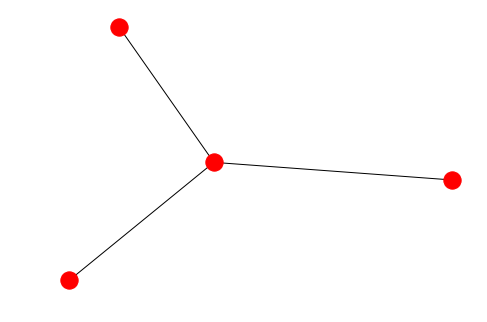

In [11]:
nx.draw(g)
plt.show()

In [12]:
A = nx.adj_matrix(g).todense()
A

matrix([[0, 1, 0, 0],
        [1, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0]], dtype=int32)

In [34]:
nodes_names = nx.get_node_attributes(g,name='sexe')

In [35]:
# one hot encoding
rows = len(nodes_names)
rows

4

In [42]:
cols = list(nodes_names.values())
cols = sorted(cols)
d = {}
i = 0
for val in cols:
    if val not in d:
        d[val] = i
        i += 1
len(d)

2

In [43]:
d

{'female': 0, 'male': 1}

In [44]:
# matrix
a = np.zeros((rows,len(d)))
a

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [45]:
col_idx = [d[n] for n in nodes_names.values()]
col_idx

[1, 0, 0, 1]

In [46]:
a[np.arange(rows), col_idx] = 1
a

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [47]:
def one_hot_encoding(node_attr):
    '''return a feature matrix from nodes attribute dict'''
    rows = len(node_attr)
    cols = list(node_attr.values())
    cols = sorted(cols)
    d = {}
    i = 0
    for val in cols:
        if val not in d:
            d[val] = i
            i += 1
    # matrix
    a = np.zeros((rows,len(d)))
    col_idx = [d[n] for n in node_attr.values()]
    a[np.arange(rows), col_idx] = 1
    return a

In [30]:
one_hot_encoding(nodes_names)

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [48]:
one_hot_encoding(nx.get_node_attributes(g, name='age'))

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [49]:
nx.get_node_attributes(g, name='sexe')

{0: 'male', 1: 'female', 2: 'female', 3: 'male'}

In [50]:
one_hot_encoding(nx.get_node_attributes(g, name='sexe'))

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

# Graph Convolution Layer

$ Z = f(\tilde D^{-1}\tilde AXW)$

$f()$ is the activation function.   
$\tilde A$ is the adjacency matrix plus the identity matrix ($A+I$).  
$\tilde D$ is the diagonal degree matrix with $\tilde D_{ii} = \sum_j{\tilde A_{ij}}$  
$X$ is the nodes' features matrix as one_hot_encoded labels
$W$ is the weight matrix such as $W \in \Bbb R^{c\times c'}$

## Step 1: linear transformation $XW$

$X \in \Bbb R^{n \times c}$ matrix with $n$ the number of nodes and $c$ the length of the encoded features.

In [63]:
X = one_hot_encoding(nx.get_node_attributes(g, name='sexe'))

In [64]:
X.shape

(4, 2)

In [68]:
X

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [90]:
W = np.random.randn(X.shape[-1], 3)
W

array([[ 0.40942606,  1.96031757, -1.91700296],
       [ 0.75520407,  1.01255964,  0.78726508]])

In [91]:
Y = np.dot(X,W)
Y

array([[ 0.75520407,  1.01255964,  0.78726508],
       [ 0.40942606,  1.96031757, -1.91700296],
       [ 0.40942606,  1.96031757, -1.91700296],
       [ 0.75520407,  1.01255964,  0.78726508]])

## Step 2: propagate weights
$ \tilde AXW$

In [92]:
# compute A
A = nx.adj_matrix(g).todense()
A

matrix([[0, 1, 0, 0],
        [1, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0]], dtype=int32)

In [93]:
I = np.eye(A.shape[0])
I

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [94]:
tA = A + I
tA

matrix([[1., 1., 0., 0.],
        [1., 1., 1., 1.],
        [0., 1., 1., 0.],
        [0., 1., 0., 1.]])

In [95]:
tAY = np.dot(tA, Y)
tAY

matrix([[ 1.16463013,  2.97287721, -1.12973788],
        [ 2.32926026,  5.94575442, -2.25947575],
        [ 0.81885213,  3.92063514, -3.83400592],
        [ 1.16463013,  2.97287721, -1.12973788]])

## Step 3: normalize
To keep a fixed feature scale, we multiply by $\tilde D^{-1}_{ii}$.

In [96]:
# diagonal degree matrix
diag = A.sum(axis=1)
diag

matrix([[1],
        [3],
        [1],
        [1]], dtype=int32)

In [97]:
tD = np.diagflat(diag)
tD

matrix([[1, 0, 0, 0],
        [0, 3, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]], dtype=int32)

In [98]:
tD_1 = np.linalg.inv(tD)
tD_1

matrix([[1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.33333333, 0.        , 0.        ],
        [0.        , 0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        ]])

In [99]:
DA = np.dot(tD_1, tAY)
DA

matrix([[ 1.16463013,  2.97287721, -1.12973788],
        [ 0.77642009,  1.98191814, -0.75315858],
        [ 0.81885213,  3.92063514, -3.83400592],
        [ 1.16463013,  2.97287721, -1.12973788]])

# Step 4: Activation

In [100]:
# ReLu
np.maximum(DA,0)

matrix([[1.16463013, 2.97287721, 0.        ],
        [0.77642009, 1.98191814, 0.        ],
        [0.81885213, 3.92063514, 0.        ],
        [1.16463013, 2.97287721, 0.        ]])

In [101]:
def GCN(X, out_dim):
    W = np.random.randn(X.shape[-1], out_dim)
    Y = np.dot(X,W)
    # compute A
    A = nx.adj_matrix(g).todense()
    I = np.eye(A.shape[0])
    tA = A + I
    tAY = np.dot(tA, Y)
    # diagonal degree matrix
    diag = A.sum(axis=1)
    tD = np.diagflat(diag)
    tD_1 = np.linalg.inv(tD)
    DA = np.dot(tD_1, tAY)
    return np.maximum(DA,0)

In [114]:
x0 = GCN(X, 5)
x1 = GCN(x0,3)
x2 = GCN(x1,1)
x2

matrix([[5.72367239],
        [4.18163839],
        [6.02173311],
        [5.72367239]])